In [ ]:
#@title Libraries
import numpy as np
import unittest
import glob
import os
import matplotlib.pyplot as plt

In [ ]:
#@title graphdatasetnextbatch
def graphdatasetnextbatch(batchsize, adj, nnodes, labels, indexinepoch, epochcompleted, numexamples, shuffle=True):
    # we take start variable and assign indexinepoch.
    start = indexinepoch

    #Here we check this condidtion and arange and shuffle the graphs list.
    if start == 0 and epochcompleted == 0 :
        idx = np.arange(0,numexamples)
        np.random.shuffle(idx)
        adj    = adj[idx]
        labels = labels[idx]
        nnodes = nnodes[idx]

    # Here we check the condition divide the list of graphs into batchsize
    if start+batchsize <= numexamples:
        indexinepoch += batchsize
        end = indexinepoch
        adjbatch = adj[start:end]
        labelsbatch = labels[start:end]
        nnodesbatch = nnodes[start:end]
        #Here we return the adjacency matrix, label list, nnodes list of batchsize.
        return adjbatch,nnodesbatch,labelsbatch

    else :
        epochcompleted += 1
        restnumexamples = numexamples - start

        adjrest = adj[start:numexamples]
        labelsrest  = labels[start:numexamples]
        nnodesrest = nnodes[start:numexamples]

        idx0 = np.arange(0,numexamples)
        np.random.shuffle(idx0)
        adj = adj[idx0]
        labels = labels[idx0]
        nnodes = nnodes[idx0]

        start = 0
        indexinepoch = batchsize - restnumexamples
        end = indexinepoch

        adjnew = adj[start:end]
        labelsnew = labels[start:end]
        nnodesnew = nnodes[start:end]

        adjbatch = np.concatenate((adjrest,adjnew),axis=0)
        labelsbatch = np.concatenate((labelsrest,labelsnew),axis=0)
        nnodesbatch = np.concatenate((nnodesrest,nnodesnew),axis=0)
        #Here we return the adjacency matrix, label list, nnodes list of batchsize.
        return adjbatch,nnodesbatch,labelsbatch

In [ ]:
#@title gnninitialize
def gnninitialize(D):
    """
    initialization, takes hyper param T and D
    T : aggregation step and D : feature vector size
    W, A, b : parameters of the network. W and A is
                initialized using normal distribution
                with sigma = 0.4 and mean = 0
    dLdW, dLdA, dLdb : gradient of the parameters
    """
    sigma = 0.4
    W = sigma * np.random.randn(D,D)
    A = sigma * np.random.randn(D)
    b = 0
    dLdW = np.zeros((D,D))
    dLdA = np.zeros((D))
    dLdb = 0
    return W, A, dLdW, dLdA, b, dLdb

In [ ]:
#@title aggregation1
def aggregation1(X,adj):
    """
    Function to calculate aggregation 1, the adjacency
    matrix is used to represent the nodes connections
    within the graph
    Args :
        X   : Feature matrix
        adj : Adjacency matrix representing the Graph

    Return :1
        a = sum of feature matrix
    """
    if adj.shape[1] == X.shape[0]:
      a = np.dot(adj, X)
      return a
    else:
      a = np.dot(np.transpose(adj),X)
      return a

In [ ]:
#@title aggregation2
def aggregation2(W,a):
    """
    Function to calculate aggregation 2, here transpose
    is used to easily calculating the aggregation using
    dot product
    Args :
        W : D x D weight matrix
        a : Output of aggregation1

    Return :
        x : W . a
    """
    x = np.dot(W,np.transpose(a))
    x = np.transpose(x)
    return x

In [ ]:
#@title relu
def relu(inp):
    """
    Rectifier Linear Unit Function, max(0,inp)
    """
    out = np.maximum(inp,1)
    return out

In [ ]:
#@title readout
def readout(X):
    """
    Function to sum all node's feature vectors
    Args :
        X : Feature vectors
    Return :
        hG : Sum of all feature vectors
    """
    hG = np.sum(X,axis=0)
    return hG

In [ ]:
#@title so
def so(hG,A,b):
    """
    Predictor function with parameter A and b
    Args :
        hG : last output of aggregation module
        A  : D size parameter
        b  : bias of predictor function
    Return :
        s : output of predictor function
    """
    s1 = np.dot(hG,A)+b
    return s1


In [ ]:
#@title sigmoid
def sigmoid(s):
        p = 1/(1+np.exp(-s))
        return p

In [ ]:
#@title output
def output(p):
    """
    output the predicted class
    Args :
        p : output of sigmoid function
    Return :
        out : predicted class 0 or 1

    """
    out = np.where((p>0.5),1,0)
    return out


In [ ]:
#@title forward
def forward(nnodes, adj, D, W, A, b, T):
    """
    forward method to calculate forward propagation of the nets
    Args :
        nnodes  : number of nodes in the batch
        adj     : adjacency matrix
        W       : parameter matrix W
        A       : parameter vector A
        b       : bias b
    Return :
        slist       : vector of predictor value
        output list : vector of predicted class`
    """
    slist = []
    outputlist = []

    X = []

    # feature vector definition
    feat =  np.zeros(D)
    feat[0] = 1

    tempnnodes = nnodes
    tempadj = adj

    for i in range(adj.shape[0]):
        X.append(np.tile(feat,[nnodes[i],1]))
        for j in range(T):
            a = aggregation1(X[i],adj[i])
            x = aggregation2(W,a)
            out = relu(x)
            X[i] = out
        # we sum the column elements
        hG = readout(X[i])
        # From here it is same as simple neural network
        s = so(hG,A,b)       # Linear part
        p = sigmoid(s)       # y_hat
        output1 = output(p)  # 0/1 value for the binary classification
        slist.append(s)
        outputlist.append(int(output1))
    return slist,outputlist, tempnnodes, tempadj

In [ ]:
#@title loss
def loss(s,y):
    """
    loss function
    Args :
        s   : vector of predictor values
        y   : vector of true class labels
    Return :
        losslist : vector of loss values
    """
    losslist = []
    for i in range (len(s)):
        if np.exp(s[i]) > np.finfo(type(np.exp(s[i]))).max:
            loss = y[i]*np.log(1+np.exp(-s[i])) + (1-y[i]) * s[i] #avoid overflow
        else :
            loss = y[i]*np.log(1+np.exp(-s[i])) + (1-y[i]) * np.log(1+np.exp(s[i]))
        losslist.append(loss)

    return losslist

In [ ]:
#@title backward
def backward(loss1, y, epsilon, tempnnodes, tempadj, D, W, A, b):
    """
    Backpropagation function to calculate and update
    the gradient of the neural network
    Args :
        loss    : loss vector
        y       : true class label
        epsilon : small pertubation value for numerical
                    differentiation

    """
    tempdLdW = np.zeros((D,D))
    tempdLdA = np.zeros((D))
    tempdLdb = 0
    batchsize = len(loss1)

    for i in range (D):
        for j in range (D):
            deltaW = np.zeros((D,D))
            deltaW[i,j] = epsilon
            Wepsilon = W+deltaW
            W = Wepsilon            # updated W based on epsilon
            sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b, T)
            lossep = loss(sep,y)
            for k in range(batchsize):
                tempdLdW[i,j] += (lossep[k] - loss1[k])/epsilon
            tempdLdW[i,j] = tempdLdW[i,j]/batchsize

    for i in range (D):
        deltaA = np.zeros((D))
        deltaA[i] = epsilon
        Aepsilon = A + deltaA
        A=Aepsilon
        sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b, T)
        lossep = loss(sep,y)
        for j in range(batchsize):
            tempdLdA[i] += (lossep[j] - loss1[j])/epsilon
        tempdLdA[i] = tempdLdA[i]/batchsize

    bepsilon = b + epsilon
    b=bepsilon
    sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b, T)
    lossep = loss(sep,y)
    for i in range(batchsize):
        tempdLdb += (lossep[i] - loss1[i])/epsilon
    tempdLdb = tempdLdb/batchsize

    dLdW = tempdLdW
    dLdA = tempdLdA
    dLdb = tempdLdb
    return dLdW, dLdA, dLdb

In [ ]:
#@title SGD
def SGD(lr, W, A, b, dLdW,dLdA,dLdb):
    newW = W - lr*dLdW
    newA = A - lr*dLdA
    newb = b - lr*dLdb
    W, A, b = newW,newA,newb
    return W, A, b

In [ ]:
#@title import torch
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title import dataset
import torch
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [ ]:
graphs = []
avgnodedegree = []
NumNodes = []
NumEdges = []

for i in range(len(dataset)):
  graphs.append(i+1)
  avgnodedegree.append(dataset[i].num_edges/dataset[i].num_nodes)
  NumNodes.append(dataset[i].num_nodes)
  NumEdges.append(dataset[i].num_edges)

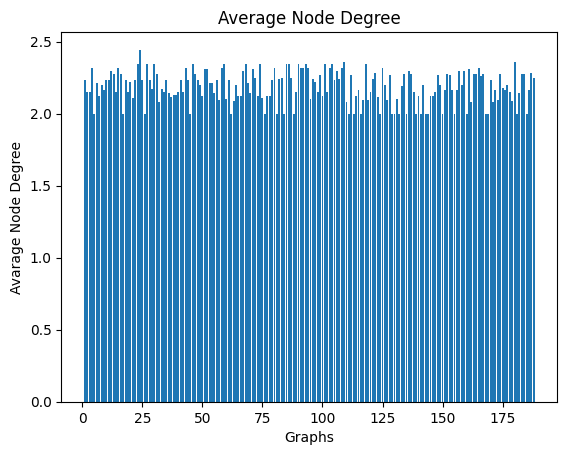

In [ ]:
plt.bar(graphs, avgnodedegree)
plt.xlabel('Graphs')
plt.ylabel('Avarage Node Degree')
plt.title('Average Node Degree')
plt.savefig('Mutag_AverageNodeDegree.png')
plt.show()

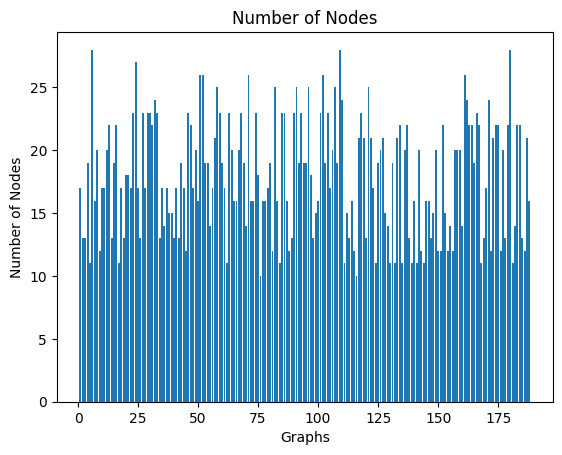

In [ ]:
plt.bar(graphs, NumNodes)
plt.xlabel('Graphs')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes')
plt.savefig('Mutag_Number of Nodes.png')
plt.show()

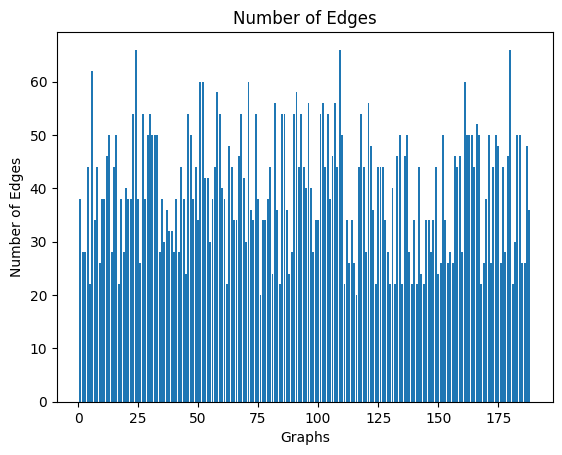

In [ ]:
plt.bar(graphs, NumEdges)
plt.xlabel('Graphs')
plt.ylabel('Number of Edges')
plt.title('Number of Edges')
plt.savefig('Mutag_Number of Edges.png')
plt.show()

In [ ]:
#@title splitting dataset
train_dataset = dataset[:120]
test_dataset = dataset[120:]

train_adj = []
train_nnodes = []
train_labels = []

test_adj = []
test_nnodes = []
test_labels = []

for i in range(len(train_dataset)):
  train_adj.append(np.array(train_dataset[i].x.tolist()))
  train_nnodes.append(train_dataset[i].num_nodes)
  train_labels.append(int(train_dataset[i].y))

for i in range(len(test_dataset)):
  test_adj.append(np.array(test_dataset[i].x.tolist()))
  test_nnodes.append(test_dataset[i].num_nodes)
  test_labels.append(int(test_dataset[i].y))

trainset_adj = np.array(train_adj,dtype=object)
trainset_nnodes = np.array(train_nnodes)
trainset_labels = np.array(train_labels)
trainset_epochcompleted = 0
trainset_indexinepoch = 0
trainset_numexamples = int(len(train_dataset))

testset_adj = np.array(test_adj,dtype=object)
testset_nnodes = np.array(test_nnodes)
testset_labels = np.array(test_labels)
testset_epochcompleted = 0
testset_indexinepoch = 0
testset_numexamples = int(len(test_dataset))

In [ ]:
#@title Parameters

#path = "/content"
#path = "/content/drive/MyDrive/Datasets/datasets/train"  #path of the dataset
batchsizetrain = len(trainset_adj)
batchsizetest = len(testset_adj)
T = 1        # Number of aggregation steps #1
D = 2              # Dimension of feature vectors #2
#optimizer = "SGD"  # Optimization methods
lr = 0.00005        # Learning rate #0.0005
#momentum  = 0.2   # Parameter for SGDM optimizer
epoch     = 200     # 500
epsilon   = 0.5      # some parameter related to learning rate    #0.5
W, A, dLdW, dLdW, dLdb, b  = gnninitialize(D)

In [ ]:
#@title Training set

# Initializing empty list to store losses and accutacies.
trainlosses = []
trainaccuracies = []
train_epoch = 0

while train_epoch < epoch:
    train_adj, train_nnodes, train_labels = graphdatasetnextbatch(batchsizetrain, trainset_adj, trainset_nnodes, trainset_labels, trainset_indexinepoch, trainset_epochcompleted, trainset_numexamples)

    train_s,train_ ,tempnnodes, tempadj = forward(train_nnodes, train_adj, D, W, A, b, T)

    train_losss = loss(train_s,train_labels)  # In general neural networks we are using y_hat for the loss function
    #calculation but here s = z, the linear part is using to calculate the loss function

    dLdW, dLdA, dLdb = backward(train_losss, train_labels, epsilon, tempnnodes, tempadj, D, W, A, b)
    W, A, b = SGD(lr, W, A, b, dLdW,dLdA,dLdb)

    trainloss = np.average(train_losss)
    trainright = np.sum(np.array(train_) == np.array(train_labels))
    trainacc = trainright/len(train_)
    trainlosses.append(trainloss)
    trainaccuracies.append(trainacc)
    train_epoch += 1

    print("epoch ",train_epoch)
    print("W :",W)
    print("A :",A)
    print("b :",b)

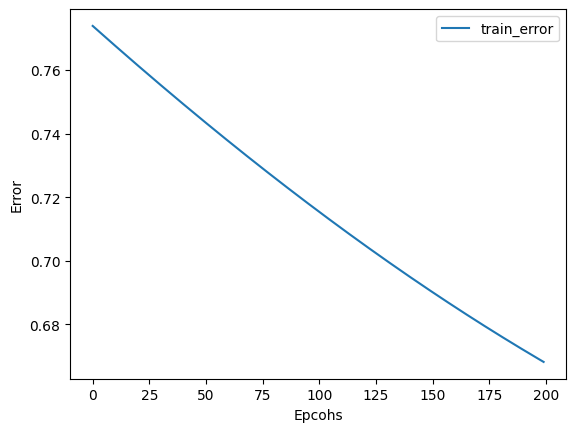

In [ ]:
x_axis = [i for i in range(epoch)]
plt.plot(x_axis , trainlosses, label='train_error')
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("Error")
plt.savefig('Mutag_errorVSepoch.png')
plt.show()

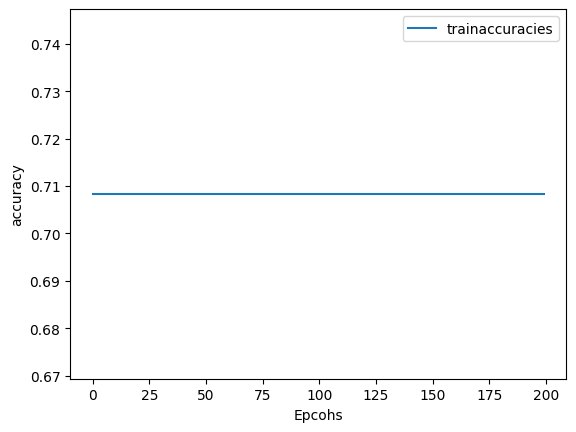

In [ ]:
x_axis = [i for i in range(epoch)]
plt.plot(x_axis , trainaccuracies, label='trainaccuracies')
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("accuracy")
plt.savefig('Mutag_errorVSaccuracies.png')
plt.show()

In [ ]:
# W, A, b

test_adj, test_nnodes, test_labels = graphdatasetnextbatch(batchsizetest, testset_adj, testset_nnodes, testset_labels, testset_indexinepoch, testset_epochcompleted, testset_numexamples)
# Forward propagation
test_s,test_ ,tempnnodes, tempadj = forward(test_nnodes,test_adj, D, W, A, b, T)
print(test_)
print(test_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1]


In [ ]:
correct_predictions = np.sum(test_ == test_labels)
accuracy = correct_predictions / len(test_) * 100
print(accuracy,"%")

58.82352941176471 %


In [ ]:
countequal  = 0
countunequal = 0

for i in range(len(test_)):
  if test_[i] == test_labels[i]:
    countequal += 1
  else:
    countunequal += 1

print(countequal)
print(countunequal)

40
28
